In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from collections import defaultdict
import seaborn as sns
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader

In [2]:
!unzip dolphin_postprocces_dataset.zip

Archive:  dolphin_postprocces_dataset.zip
   creating: dolphin_postprocces_dataset/0/
  inflating: dolphin_postprocces_dataset/0/0_DSC_1894.JPG  
  inflating: dolphin_postprocces_dataset/0/1_DSC_1665.JPG  
  inflating: dolphin_postprocces_dataset/0/10_DSC_0193.JPG  
  inflating: dolphin_postprocces_dataset/0/100_DSC_0489.JPG  
  inflating: dolphin_postprocces_dataset/0/101_DSC_0563.JPG  
  inflating: dolphin_postprocces_dataset/0/102_DSC_0565.JPG  
  inflating: dolphin_postprocces_dataset/0/103_DSC_0180.JPG  
  inflating: dolphin_postprocces_dataset/0/104_DSC_0011.JPG  
  inflating: dolphin_postprocces_dataset/0/105_DSC_3636.JPG  
  inflating: dolphin_postprocces_dataset/0/106_DSC_0049.JPG  
  inflating: dolphin_postprocces_dataset/0/107_DSC_3714.JPG  
  inflating: dolphin_postprocces_dataset/0/108_DSC_0567.JPG  
  inflating: dolphin_postprocces_dataset/0/109_DSC_1551.JPG  
  inflating: dolphin_postprocces_dataset/0/11_DSC_2015.JPG  
  inflating: dolphin_postprocces_dataset/0/110_DSC_3

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("./")
image_path = data_path / "dolphin_postprocces_dataset"

In [4]:
data_transform_resize = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

class ResNetPad():
    def __call__(self, image, shape=(224, 224)):
        y_, x_ = shape
        y, x = image.size[1], image.size[0]
        y_pad = (y_-y)
        x_pad = (x_-x)
        return np.pad(image, ((y_pad//2, y_pad//2 + y_pad%2),
                         (x_pad//2, x_pad//2 + x_pad%2),
                         (0, 0)),
                      mode = 'constant')

data_transform_padding = transforms.Compose([
    ResNetPad(),
    transforms.ToTensor()
])

In [5]:
data_resize = datasets.ImageFolder(root=data_path / "dolphin_postprocces_dataset",
                                  transform=data_transform_resize)

data_padding = datasets.ImageFolder(root=data_path / "dolphin_postprocces_dataset",
                                  transform=data_transform_padding)

In [6]:
from torch.utils.data import DataLoader

dataloader_resize = DataLoader(data_resize, batch_size=1, shuffle=False)
dataloader_padding = DataLoader(data_padding, batch_size=1, shuffle=False)

In [15]:
from torch.utils.data import random_split

generator = torch.Generator().manual_seed(42)

train_resize, val_resize, test_resize = random_split(data_resize,
                                                     [0.7, 0.1, 0.2],
                                                     generator=generator)
train_padding, val_padding, test_padding = random_split(data_padding,
                                                        [0.7, 0.1, 0.2],
                                                        generator=generator)

In [16]:
train_loader_resize = DataLoader(train_resize, batch_size=1, shuffle=False)
val_loader_resize = DataLoader(val_resize, batch_size=1, shuffle=False)
test_loader_resize = DataLoader(test_resize, batch_size=1, shuffle=False)

train_loader_padding = DataLoader(train_padding, batch_size=1, shuffle=False)
val_loader_padding = DataLoader(val_padding, batch_size=1, shuffle=False)
test_loader_padding = DataLoader(test_padding, batch_size=1, shuffle=False)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Модель

In [8]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights)
resnet34 = models.resnet34(weights=models.ResNet34_Weights)
resnet50 = models.resnet50(weights=models.ResNet50_Weights)
resnet101 = models.resnet101(weights=models.ResNet101_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 74.7MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Download

In [9]:
resnet18.to(device)
resnet34.to(device)
resnet50.to(device)
resnet101.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Обучение

## Функции

In [10]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    criterion = nn.CrossEntropyLoss()

    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            outputs = model(data)
            loss = criterion(outputs, target)

        loss_log.append(loss.item())

        predicted = torch.argmax(outputs, dim=1)
        acc = (predicted == target).sum() / data.shape[0]

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:

        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        predicted = torch.argmax(outputs, dim=1)
        acc = (predicted == target).sum() / data.shape[0]

        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [11]:
def draw_model_plot(acc, val_acc, loss, val_loss):

    epoch_range = range(len(acc))

    plt.plot(epoch_range, acc, label='Training accuracy')
    plt.plot(epoch_range, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epoch_range, loss, label='Training loss')
    plt.plot(epoch_range, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    plt.show()

In [12]:
def make_preds(model, loader):
    model.eval()
    preds = []

    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            outputs = model(data)

        predicted = torch.argmax(outputs, dim=1)
        preds.append(predicted.item())

    return np.array(preds)

## ResNet18 + resize

In [13]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
optimizer = optim.AdamW(resnet18.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet18, optimizer, 30,
                                                                 train_loader_resize,
                                                                 val_loader_resize)

Epoch 0
 train loss: 0.9080036433139707, train acc: 0.5735294117647058
 val loss: 16.282072228113844, val acc: 0.4583333333333333

Epoch 1
 train loss: 0.7969696577857522, train acc: 0.5529411764705883
 val loss: 45.49184658316275, val acc: 0.4583333333333333

Epoch 2
 train loss: 0.7815893235780736, train acc: 0.5558823529411765
 val loss: 1.0606008503370201, val acc: 0.4583333333333333

Epoch 3
 train loss: 0.7748189303585712, train acc: 0.55
 val loss: 10.51114755352349, val acc: 0.4583333333333333

Epoch 4
 train loss: 0.7403056557564175, train acc: 0.5735294117647058
 val loss: 5.858119550224728, val acc: 0.4583333333333333

Epoch 5
 train loss: 0.752624180310351, train acc: 0.5676470588235294
 val loss: 6.749067999073304, val acc: 0.4583333333333333

Epoch 6
 train loss: 0.7583611100145122, train acc: 0.55
 val loss: 1.0528438131635387, val acc: 0.4583333333333333

Epoch 7
 train loss: 0.7571850211523912, train acc: 0.5411764705882353
 val loss: 2.2196023060168955, val acc: 0.458

In [21]:
epoch_num = 30
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

10200 30 30


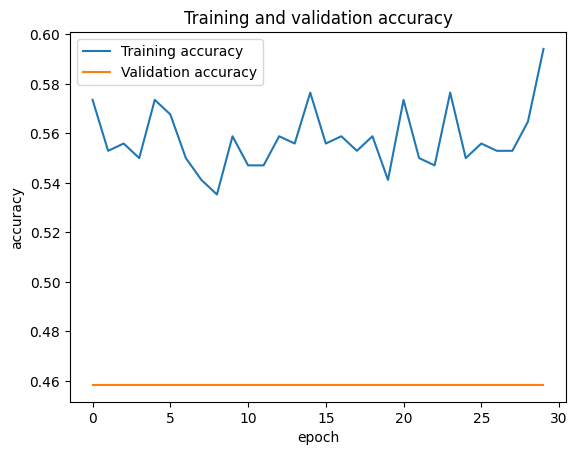

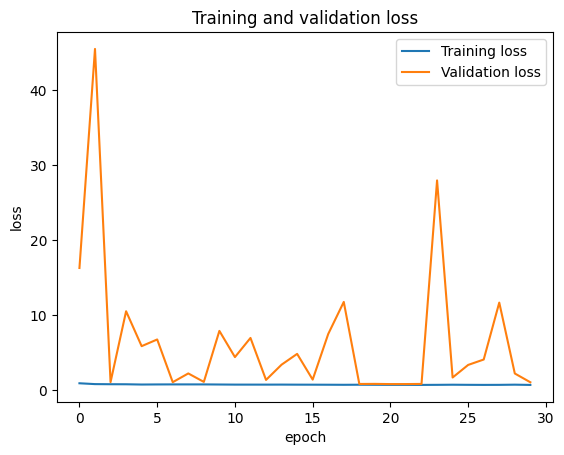

In [22]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [23]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
optimizer = optim.AdamW(resnet18.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet18, optimizer, 1,
                                                                 train_loader_resize,
                                                                 val_loader_resize)

Epoch 0
 train loss: 0.8036947282524232, train acc: 0.5647058823529412
 val loss: 1.605021406236725, val acc: 0.625



In [30]:
epoch_num = 1
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

340 1 1


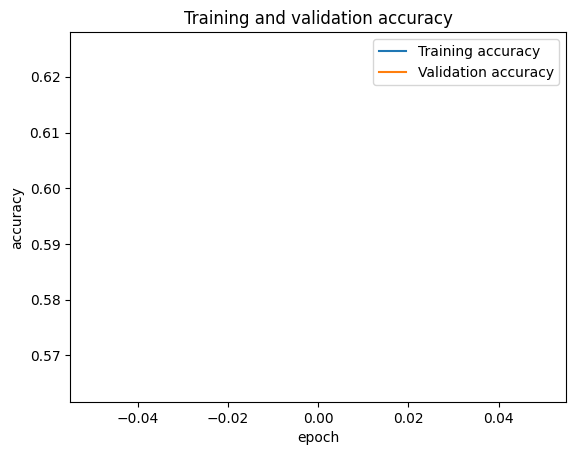

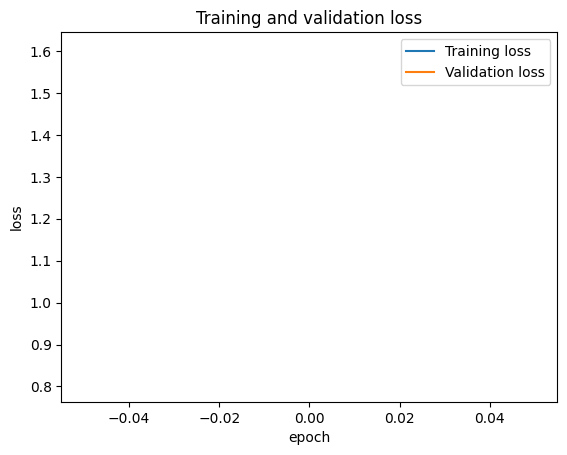

In [31]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [32]:
test_loss, test_acc = test(resnet18, test_loader_resize)
test_loss, test_acc

(1.4314908004826723, 0.6391752577319587)

In [34]:
from sklearn.metrics import classification_report

preds = make_preds(resnet18, test_loader_resize)

labels = []
for _, label in test_loader_resize:
    labels.append(label)
labels = np.array(labels)

print('Test dataset')
print(classification_report(preds, labels))

preds = make_preds(resnet18, dataloader_resize)

labels = []
for _, label in dataloader_resize:
    labels.append(label)
labels = np.array(labels)

print('All dataset')
print(classification_report(preds, labels))

Test dataset
              precision    recall  f1-score   support

           0       0.18      0.43      0.26        14
           1       0.88      0.67      0.76        83

    accuracy                           0.64        97
   macro avg       0.53      0.55      0.51        97
weighted avg       0.77      0.64      0.69        97

All dataset
              precision    recall  f1-score   support

           0       0.32      0.53      0.40       115
           1       0.82      0.66      0.73       370

    accuracy                           0.63       485
   macro avg       0.57      0.59      0.57       485
weighted avg       0.70      0.63      0.65       485



In [ ]:
print(len(preds))

4411


In [ ]:
# torch.save(resnet18.state_dict(), 'resnet18_resize.pth')

## ResNet18 + padding

In [35]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights)
resnet18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
optimizer = optim.AdamW(resnet18.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet18, optimizer, 30,
                                                                 train_loader_padding,
                                                                 val_loader_padding)

Epoch 0
 train loss: 0.8704071597743999, train acc: 0.5411764705882353
 val loss: 0.8878637353579203, val acc: 0.5208333333333334

Epoch 1
 train loss: 0.756452973055489, train acc: 0.5676470588235294
 val loss: 1.0414492444445689, val acc: 0.5208333333333334

Epoch 2
 train loss: 0.7528037990279057, train acc: 0.5676470588235294
 val loss: 1.1718631274998188, val acc: 0.5208333333333334

Epoch 3
 train loss: 0.7362924502176397, train acc: 0.5676470588235294
 val loss: 1.1598739398953815, val acc: 0.5208333333333334

Epoch 4
 train loss: 0.737331025433891, train acc: 0.5941176470588235
 val loss: 1.1609268070509036, val acc: 0.5208333333333334

Epoch 5
 train loss: 0.745558589455836, train acc: 0.5617647058823529
 val loss: 1.4091305210871117, val acc: 0.5208333333333334

Epoch 6
 train loss: 0.7472596306134672, train acc: 0.5529411764705883
 val loss: 0.9479361679404974, val acc: 0.5208333333333334

Epoch 7
 train loss: 0.7280666027656373, train acc: 0.5647058823529412
 val loss: 1.02

In [37]:
epoch_num = 30
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

10200 30 30


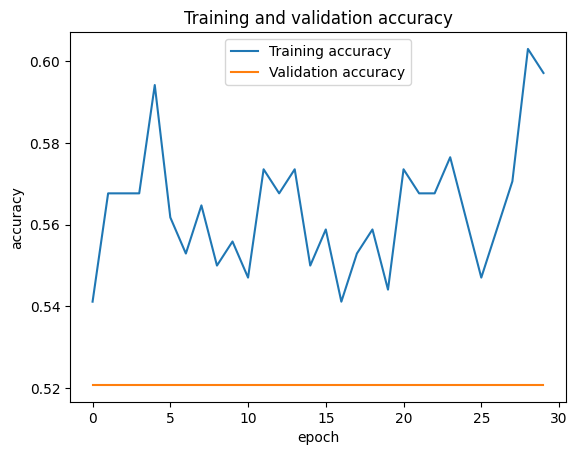

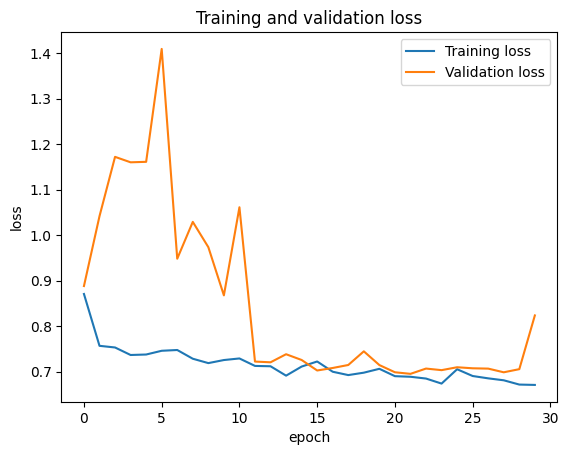

In [38]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [39]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
optimizer = optim.AdamW(resnet18.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet18, optimizer, 4,
                                                                 train_loader_padding,
                                                                 val_loader_padding)

Epoch 0
 train loss: 0.8656381845748161, train acc: 0.5588235294117647
 val loss: 2.8692848692153348, val acc: 0.4166666666666667

Epoch 1
 train loss: 0.7699263659908491, train acc: 0.5588235294117647
 val loss: 0.7960290166859826, val acc: 0.5

Epoch 2
 train loss: 0.7487577476922204, train acc: 0.5588235294117647
 val loss: 2.3398099975032287, val acc: 0.5208333333333334

Epoch 3
 train loss: 0.7366250165683381, train acc: 0.5705882352941176
 val loss: 1.0323787899493861, val acc: 0.5208333333333334



In [42]:
test_loss, test_acc = test(resnet18, test_loader_padding)
test_loss, test_acc

(0.736222062658365, 0.5979381443298969)

In [43]:
from sklearn.metrics import classification_report

preds = make_preds(resnet18, test_loader_padding)

labels = []
for _, label in test_loader_padding:
    labels.append(label)
labels = np.array(labels)

print('Test dataset')
print(classification_report(preds, labels))

preds = make_preds(resnet18, dataloader_padding)

labels = []
for _, label in dataloader_padding:
    labels.append(label)
labels = np.array(labels)

print('All dataset')
print(classification_report(preds, labels))

Test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.60      0.75        97

    accuracy                           0.60        97
   macro avg       0.50      0.30      0.37        97
weighted avg       1.00      0.60      0.75        97



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.61      0.76       485

    accuracy                           0.61       485
   macro avg       0.50      0.31      0.38       485
weighted avg       1.00      0.61      0.76       485



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# torch.save(resnet18.state_dict(), 'resnet18_padding.pth')

## ResNet34 + resize

In [44]:
resnet34 = models.resnet34(weights=models.ResNet34_Weights)
resnet34.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
optimizer = optim.AdamW(resnet34.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet34, optimizer, 30,
                                                                 train_loader_resize,
                                                                 val_loader_resize)

Epoch 0
 train loss: 0.9016643592923441, train acc: 0.5588235294117647
 val loss: 2.737262280037006, val acc: 0.4375

Epoch 1
 train loss: 0.8033898090724559, train acc: 0.55
 val loss: 42.83592246300865, val acc: 0.4791666666666667

Epoch 2
 train loss: 0.7664125019574867, train acc: 0.5323529411764706
 val loss: 29.655424251536413, val acc: 0.6458333333333334

Epoch 3
 train loss: 0.7555344186284962, train acc: 0.5617647058823529
 val loss: 3.996229524366678, val acc: 0.5208333333333334

Epoch 4
 train loss: 0.7469672224758303, train acc: 0.55
 val loss: 17.69464931584048, val acc: 0.5416666666666666

Epoch 5
 train loss: 0.7372351979946389, train acc: 0.5705882352941176
 val loss: 1.7504137370880641, val acc: 0.6875

Epoch 6
 train loss: 0.7375539035043296, train acc: 0.5588235294117647
 val loss: 1.9810012355446815, val acc: 0.3958333333333333

Epoch 7
 train loss: 0.7230885173468029, train acc: 0.5676470588235294
 val loss: 1.7633760410050552, val acc: 0.5

Epoch 8
 train loss: 0.

In [46]:
epoch_num = 30
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

10200 30 30


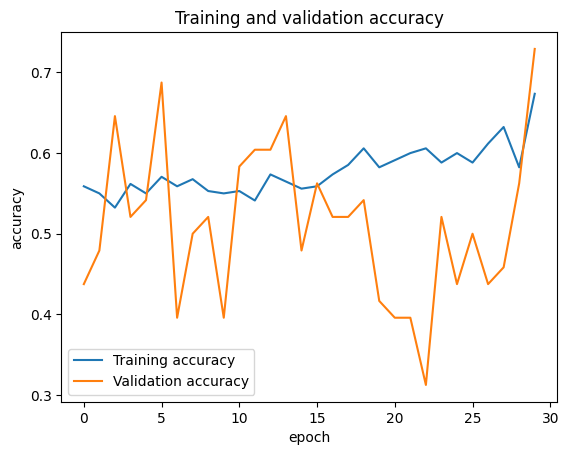

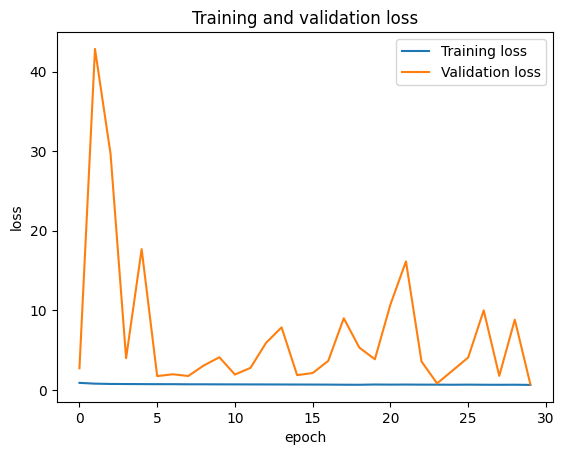

In [47]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [48]:
resnet34 = models.resnet34(weights=models.ResNet34_Weights)
resnet34.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
optimizer = optim.AdamW(resnet34.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet34, optimizer, 4,
                                                                 train_loader_resize,
                                                                 val_loader_resize)

Epoch 0
 train loss: 0.8964414116351263, train acc: 0.5676470588235294
 val loss: 0.9796620129685228, val acc: 0.625

Epoch 1
 train loss: 0.7857191490612048, train acc: 0.5411764705882353
 val loss: 3.4834785277218665, val acc: 0.3333333333333333

Epoch 2
 train loss: 0.763069278385271, train acc: 0.5264705882352941
 val loss: 1.479040452793318, val acc: 0.3541666666666667

Epoch 3
 train loss: 0.7483525340171421, train acc: 0.5441176470588235
 val loss: 1.3183934330763047, val acc: 0.3541666666666667



In [50]:
epoch_num = 4
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

1360 4 4


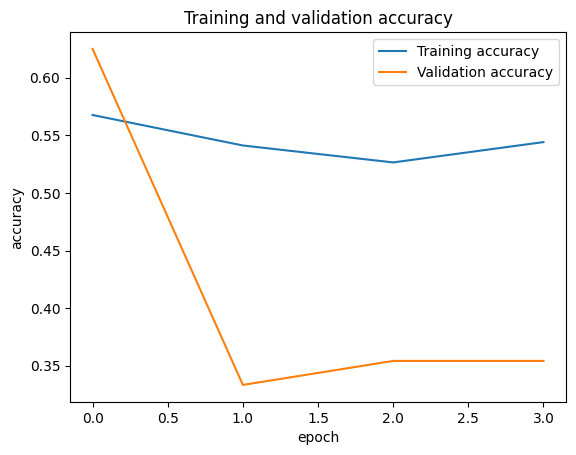

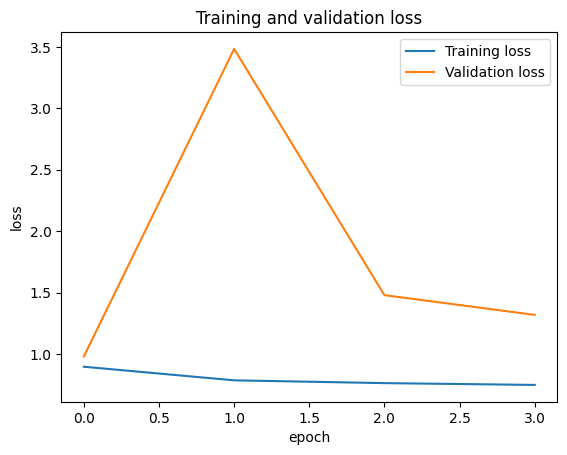

In [51]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [52]:
test_loss, test_acc = test(resnet34, test_loader_resize)
test_loss, test_acc

(1.7034321224758613, 0.3917525773195876)

In [53]:
from sklearn.metrics import classification_report

preds = make_preds(resnet34, test_loader_resize)

labels = []
for _, label in test_loader_resize:
    labels.append(label)
labels = np.array(labels)

print('Test dataset')
print(classification_report(preds, labels))

preds = make_preds(resnet34, dataloader_resize)

labels = []
for _, label in dataloader_resize:
    labels.append(label)
labels = np.array(labels)

print('All dataset')
print(classification_report(preds, labels))

Test dataset
              precision    recall  f1-score   support

           0       0.45      0.27      0.34        56
           1       0.36      0.56      0.44        41

    accuracy                           0.39        97
   macro avg       0.41      0.41      0.39        97
weighted avg       0.41      0.39      0.38        97

All dataset
              precision    recall  f1-score   support

           0       0.35      0.27      0.30       248
           1       0.39      0.49      0.43       237

    accuracy                           0.37       485
   macro avg       0.37      0.38      0.37       485
weighted avg       0.37      0.37      0.37       485



In [ ]:
# torch.save(resnet18.state_dict(), 'resnet34_resize.pth')

## ResNet34 + padding

In [54]:
resnet34 = models.resnet34(weights=models.ResNet34_Weights)
resnet34.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
optimizer = optim.AdamW(resnet34.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet34, optimizer, 30,
                                                                 train_loader_padding,
                                                                 val_loader_padding)

Epoch 0
 train loss: 0.8584246869445504, train acc: 0.5411764705882353
 val loss: 2.323574254910151, val acc: 0.4791666666666667

Epoch 1
 train loss: 0.7528250377406093, train acc: 0.5470588235294118
 val loss: 2.990940008307613, val acc: 0.4791666666666667

Epoch 2
 train loss: 0.7326241138665115, train acc: 0.5705882352941176
 val loss: 2.1906911485518017, val acc: 0.375

Epoch 3
 train loss: 0.7114520672927884, train acc: 0.5588235294117647
 val loss: 1.712121474246184, val acc: 0.5208333333333334

Epoch 4
 train loss: 0.7432669964783332, train acc: 0.5617647058823529
 val loss: 1.579845971117417, val acc: 0.3541666666666667

Epoch 5
 train loss: 0.7233794307884048, train acc: 0.5558823529411765
 val loss: 2.154698694124818, val acc: 0.4791666666666667

Epoch 6
 train loss: 0.7081884933087755, train acc: 0.5441176470588235
 val loss: 1.8688401769225795, val acc: 0.375

Epoch 7
 train loss: 0.6925446498043397, train acc: 0.55
 val loss: 2.283097232497918, val acc: 0.3541666666666667

In [56]:
epoch_num = 30
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

10200 30 30


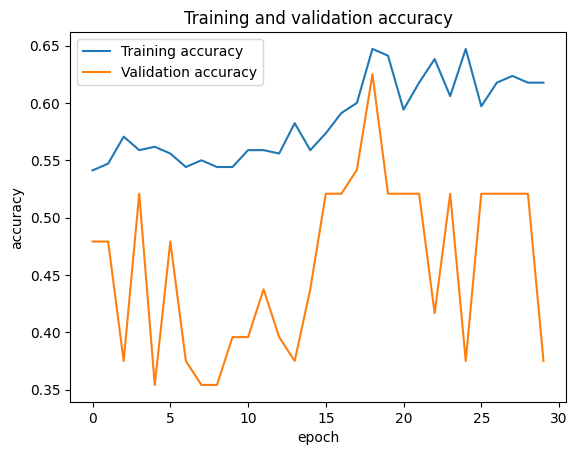

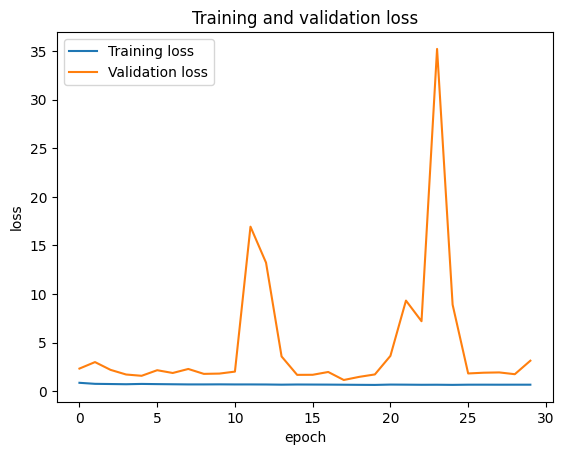

In [57]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [58]:
resnet34 = models.resnet34(weights=models.ResNet34_Weights)
resnet34.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
optimizer = optim.AdamW(resnet34.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet34, optimizer, 18,
                                                                 train_loader_padding,
                                                                 val_loader_padding)

Epoch 0
 train loss: 0.8563625317614745, train acc: 0.5588235294117647
 val loss: 4.631148930755444, val acc: 0.3958333333333333

Epoch 1
 train loss: 0.7612375298405395, train acc: 0.5676470588235294
 val loss: 1.3917384321490924, val acc: 0.4791666666666667

Epoch 2
 train loss: 0.7367014648283229, train acc: 0.5588235294117647
 val loss: 0.7232674745221933, val acc: 0.5208333333333334

Epoch 3
 train loss: 0.7454063094933243, train acc: 0.5617647058823529
 val loss: 0.8407037332653999, val acc: 0.4166666666666667

Epoch 4
 train loss: 0.7259048335911596, train acc: 0.5588235294117647
 val loss: 0.9730629461507002, val acc: 0.4375

Epoch 5
 train loss: 0.7160960721180719, train acc: 0.5617647058823529
 val loss: 1.2651540466273825, val acc: 0.3541666666666667

Epoch 6
 train loss: 0.7067845904432676, train acc: 0.5588235294117647
 val loss: 1.4526761210290715, val acc: 0.3541666666666667

Epoch 7
 train loss: 0.692988499473123, train acc: 0.55
 val loss: 3.315387644519736, val acc: 0

In [60]:
epoch_num = 18
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

6120 18 18


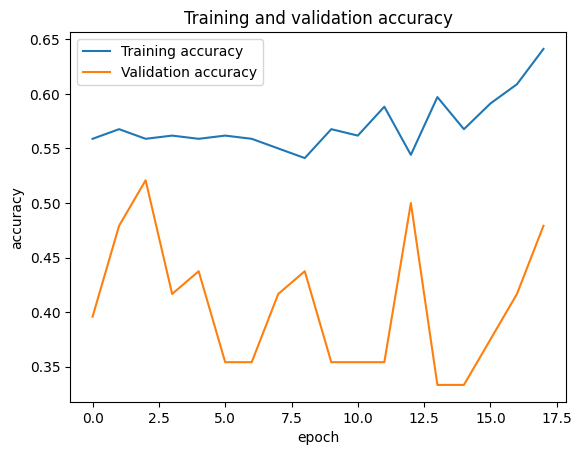

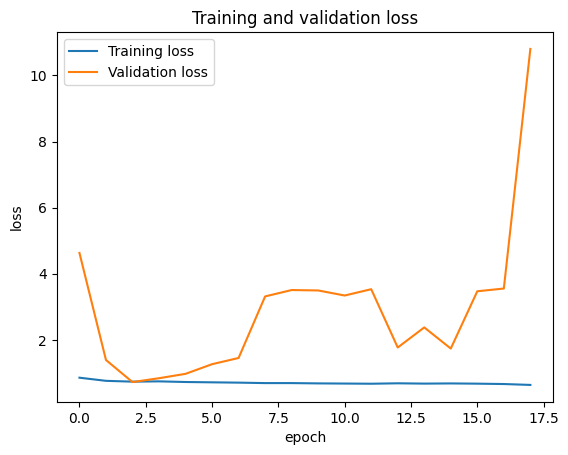

In [61]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [62]:
test_loss, test_acc = test(resnet34, test_loader_padding)
test_loss, test_acc

(8.458894581713588, 0.5773195876288659)

In [63]:
from sklearn.metrics import classification_report

preds = make_preds(resnet34, test_loader_padding)

labels = []
for _, label in test_loader_padding:
    labels.append(label)
labels = np.array(labels)

print('Test dataset')
print(classification_report(preds, labels))

preds = make_preds(resnet34, dataloader_padding)

labels = []
for _, label in dataloader_padding:
    labels.append(label)
labels = np.array(labels)

print('All dataset')
print(classification_report(preds, labels))

Test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.97      0.59      0.73        95

    accuracy                           0.58        97
   macro avg       0.48      0.29      0.37        97
weighted avg       0.95      0.58      0.72        97

All dataset
              precision    recall  f1-score   support

           0       0.04      0.47      0.08        17
           1       0.97      0.62      0.75       468

    accuracy                           0.61       485
   macro avg       0.51      0.54      0.42       485
weighted avg       0.94      0.61      0.73       485



In [ ]:
# torch.save(resnet18.state_dict(), 'resnet34_padding.pth')

## ResNet50 + resize

In [64]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights)
resnet50.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [65]:
optimizer = optim.AdamW(resnet50.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet50, optimizer, 30,
                                                                 train_loader_resize,
                                                                 val_loader_resize)

Epoch 0
 train loss: 0.9352796030997792, train acc: 0.5705882352941176
 val loss: 1.832652470609067, val acc: 0.4583333333333333

Epoch 1
 train loss: 0.7572797040948096, train acc: 0.5441176470588235
 val loss: 1.7205072583941121, val acc: 0.4583333333333333

Epoch 2
 train loss: 0.7369232732583495, train acc: 0.5794117647058824
 val loss: 3.0591637900991677, val acc: 0.5

Epoch 3
 train loss: 0.73204714105848, train acc: 0.5735294117647058
 val loss: 2.1364473373008273, val acc: 0.4583333333333333

Epoch 4
 train loss: 0.7206945552107166, train acc: 0.5529411764705883
 val loss: 1.7414636947214603, val acc: 0.4583333333333333

Epoch 5
 train loss: 0.7137003185337081, train acc: 0.5470588235294118
 val loss: 2.2252909371163696, val acc: 0.4583333333333333

Epoch 6
 train loss: 0.7135030563263333, train acc: 0.55
 val loss: 2.4742401961702853, val acc: 0.4583333333333333

Epoch 7
 train loss: 0.7166891451705905, train acc: 0.5411764705882353
 val loss: 3.5066810937729165, val acc: 0.45

In [66]:
epoch_num = 30
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

10200 30 30


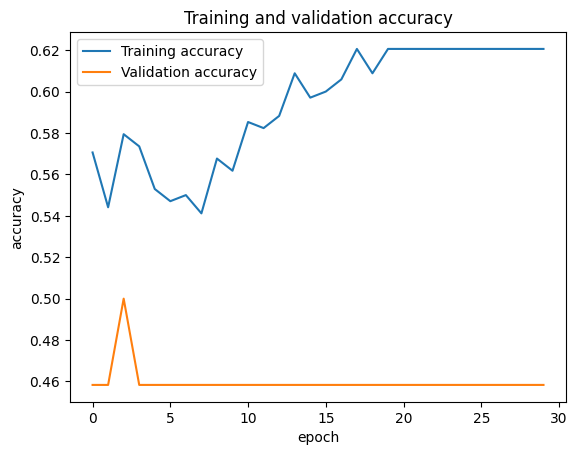

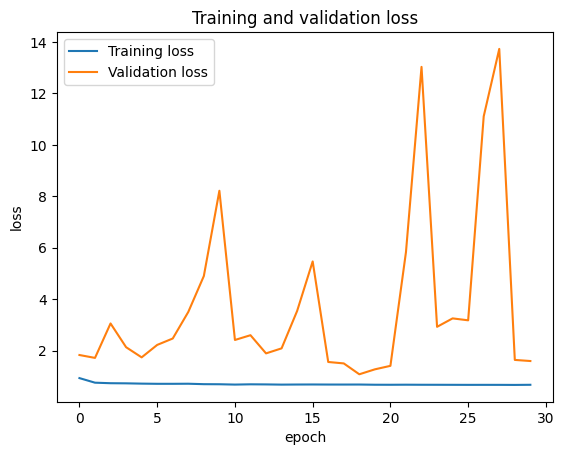

In [67]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [76]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights)
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [77]:
optimizer = optim.AdamW(resnet50.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet50, optimizer, 3,
                                                                 train_loader_resize,
                                                                 val_loader_resize)

Epoch 0
 train loss: 0.8923521350754205, train acc: 0.5676470588235294
 val loss: 216.80056246370077, val acc: 0.4583333333333333

Epoch 1
 train loss: 0.7604724542840439, train acc: 0.538235294117647
 val loss: 0.8438830528563509, val acc: 0.4583333333333333

Epoch 2
 train loss: 0.7488692619783037, train acc: 0.5264705882352941
 val loss: 0.824572166964875, val acc: 0.4583333333333333



In [78]:
epoch_num = 3
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

1020 3 3


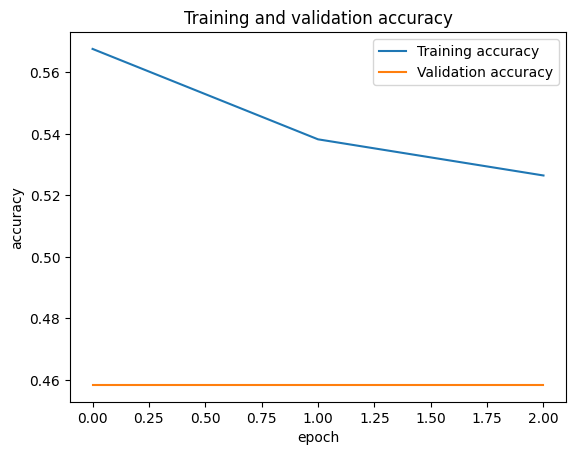

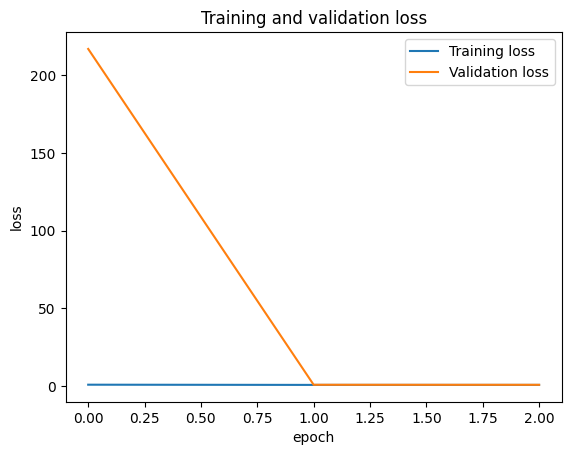

In [79]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [80]:
test_loss, test_acc = test(resnet50, test_loader_resize)
test_loss, test_acc

(0.9358684443033731, 0.6597938144329897)

In [81]:
from sklearn.metrics import classification_report

preds = make_preds(resnet50, test_loader_resize)

labels = []
for _, label in test_loader_resize:
    labels.append(label)
labels = np.array(labels)

print('Test dataset')
print(classification_report(preds, labels))

preds = make_preds(resnet50, dataloader_resize)

labels = []
for _, label in dataloader_resize:
    labels.append(label)
labels = np.array(labels)

print('All dataset')
print(classification_report(preds, labels))

Test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.66      0.80        97

    accuracy                           0.66        97
   macro avg       0.50      0.33      0.40        97
weighted avg       1.00      0.66      0.80        97



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.61      0.76       485

    accuracy                           0.61       485
   macro avg       0.50      0.31      0.38       485
weighted avg       1.00      0.61      0.76       485



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# torch.save(resnet18.state_dict(), 'resnet50_resize.pth')

## ResNet50 + padding

In [82]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights)
resnet50.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [83]:
optimizer = optim.AdamW(resnet50.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet50, optimizer, 30,
                                                                 train_loader_padding,
                                                                 val_loader_padding)

Epoch 0
 train loss: 0.8477999434203786, train acc: 0.5647058823529412
 val loss: 2.614216777806481, val acc: 0.5208333333333334

Epoch 1
 train loss: 0.7408053380163276, train acc: 0.5470588235294118
 val loss: 3.0278163347393274, val acc: 0.5208333333333334

Epoch 2
 train loss: 0.7092202522518004, train acc: 0.5705882352941176
 val loss: 2.0019046974678836, val acc: 0.5208333333333334

Epoch 3
 train loss: 0.6701432260301183, train acc: 0.6176470588235294
 val loss: 1.9475932916005452, val acc: 0.5625

Epoch 4
 train loss: 0.7161721388425897, train acc: 0.5882352941176471
 val loss: 2.500015901401639, val acc: 0.5208333333333334

Epoch 5
 train loss: 0.6929523361956372, train acc: 0.5617647058823529
 val loss: 1.8776037332912285, val acc: 0.5625

Epoch 6
 train loss: 0.6891025525462978, train acc: 0.5558823529411765
 val loss: 1.742373136182626, val acc: 0.5208333333333334

Epoch 7
 train loss: 0.6881734251099474, train acc: 0.5617647058823529
 val loss: 1.5822343587254484, val acc:

In [84]:
epoch_num = 30
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

10200 30 30


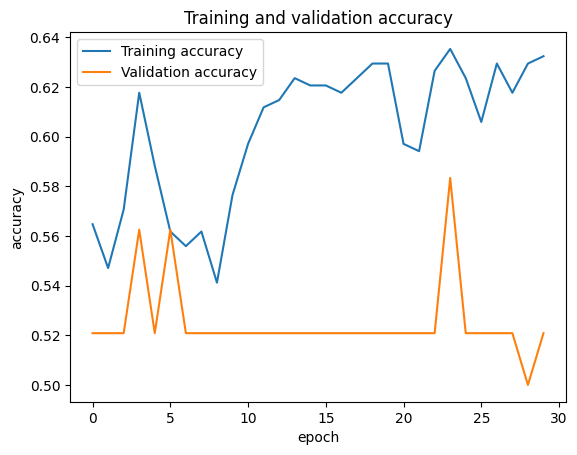

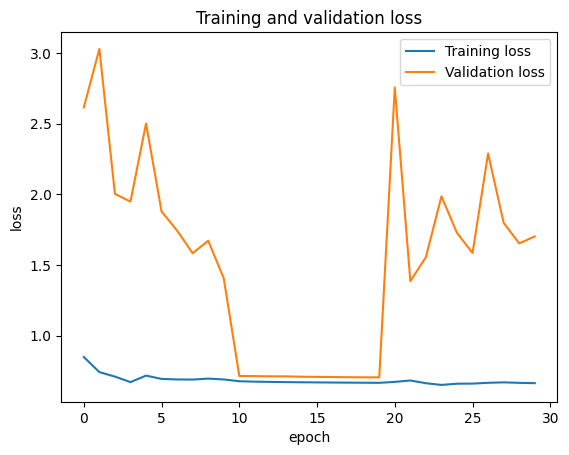

In [85]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [86]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights)
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [87]:
optimizer = optim.AdamW(resnet50.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet50, optimizer, 11,
                                                                 train_loader_padding,
                                                                 val_loader_padding)

Epoch 0
 train loss: 0.840652135209016, train acc: 0.5529411764705883
 val loss: 2.6231386214494705, val acc: 0.4791666666666667

Epoch 1
 train loss: 0.7395432734533268, train acc: 0.5735294117647058
 val loss: 2.3108403980731964, val acc: 0.5

Epoch 2
 train loss: 0.7147955058032975, train acc: 0.538235294117647
 val loss: 1.538549735812315, val acc: 0.5416666666666666

Epoch 3
 train loss: 0.7057214181651087, train acc: 0.5470588235294118
 val loss: 1.1248722109788407, val acc: 0.5625

Epoch 4
 train loss: 0.7134792499134646, train acc: 0.5529411764705883
 val loss: 1.2276863767765462, val acc: 0.5208333333333334

Epoch 5
 train loss: 0.6923042003284482, train acc: 0.5470588235294118
 val loss: 1.9250544843574364, val acc: 0.5208333333333334

Epoch 6
 train loss: 0.6854722365298692, train acc: 0.5617647058823529
 val loss: 1.5496475466837485, val acc: 0.5208333333333334

Epoch 7
 train loss: 0.6813906540327213, train acc: 0.5647058823529412
 val loss: 1.7898665225754182, val acc: 0.

In [88]:
epoch_num = 11
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

3740 11 11


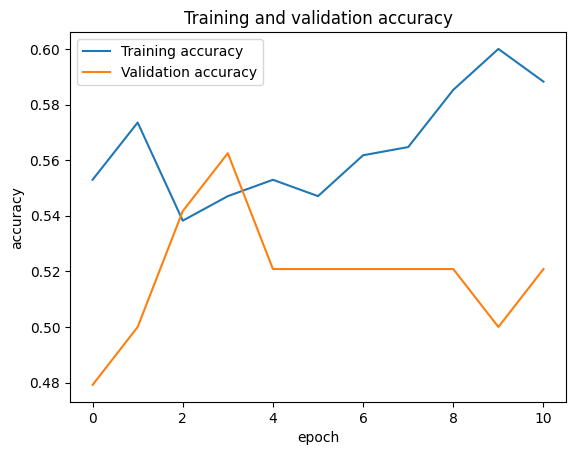

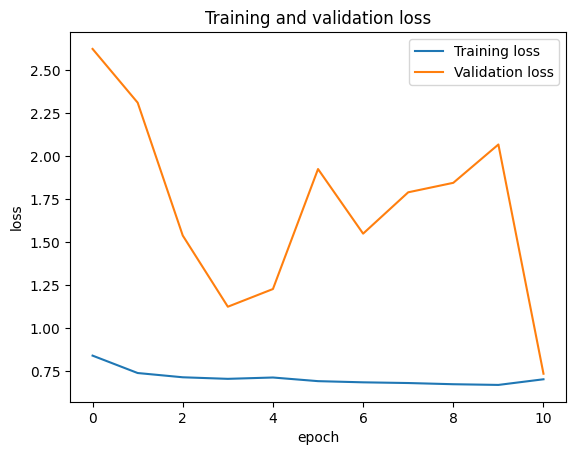

In [89]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [90]:
test_loss, test_acc = test(resnet50, test_loader_padding)
test_loss, test_acc

(0.7589593889172545, 0.5979381443298969)

In [91]:
from sklearn.metrics import classification_report

preds = make_preds(resnet50, test_loader_padding)

labels = []
for _, label in test_loader_padding:
    labels.append(label)
labels = np.array(labels)

print('Test dataset')
print(classification_report(preds, labels))

preds = make_preds(resnet50, dataloader_padding)

labels = []
for _, label in dataloader_padding:
    labels.append(label)
labels = np.array(labels)

print('All dataset')
print(classification_report(preds, labels))

Test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.60      0.75        97

    accuracy                           0.60        97
   macro avg       0.50      0.30      0.37        97
weighted avg       1.00      0.60      0.75        97



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.61      0.76       485

    accuracy                           0.61       485
   macro avg       0.50      0.31      0.38       485
weighted avg       1.00      0.61      0.76       485



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# torch.save(resnet50.state_dict(), 'resnet50_padding.pth')

## ResNet101 + resize

In [92]:
resnet101 = models.resnet101(weights=models.ResNet101_Weights)
resnet101.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [93]:
optimizer = optim.AdamW(resnet101.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet101, optimizer, 30,
                                                                 train_loader_resize,
                                                                 val_loader_resize)

Epoch 0
 train loss: 0.9000943769454298, train acc: 0.5411764705882353
 val loss: 34.921694880972304, val acc: 0.4583333333333333

Epoch 1
 train loss: 0.7602579796796336, train acc: 0.5588235294117647
 val loss: 84.36036354210228, val acc: 0.4583333333333333

Epoch 2
 train loss: 0.7369417840286213, train acc: 0.5705882352941176
 val loss: 31.025013015096103, val acc: 0.4583333333333333

Epoch 3
 train loss: 0.7222315933774499, train acc: 0.5558823529411765
 val loss: 14.252148755127564, val acc: 0.4583333333333333

Epoch 4
 train loss: 0.7167681051527752, train acc: 0.5617647058823529
 val loss: 6.851836331188679, val acc: 0.4583333333333333

Epoch 5
 train loss: 0.7165557176751249, train acc: 0.5470588235294118
 val loss: 66.16205746877556, val acc: 0.4583333333333333

Epoch 6
 train loss: 0.7030984546331799, train acc: 0.5588235294117647
 val loss: 3.802169214292723, val acc: 0.4583333333333333

Epoch 7
 train loss: 0.6958385670448051, train acc: 0.5647058823529412
 val loss: 1.567

In [94]:
epoch_num = 30
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

10200 30 30


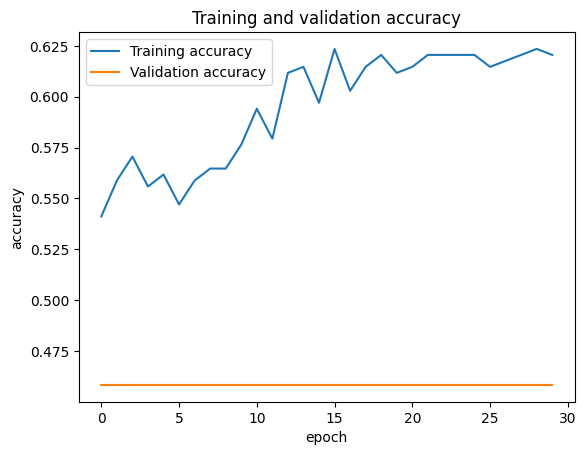

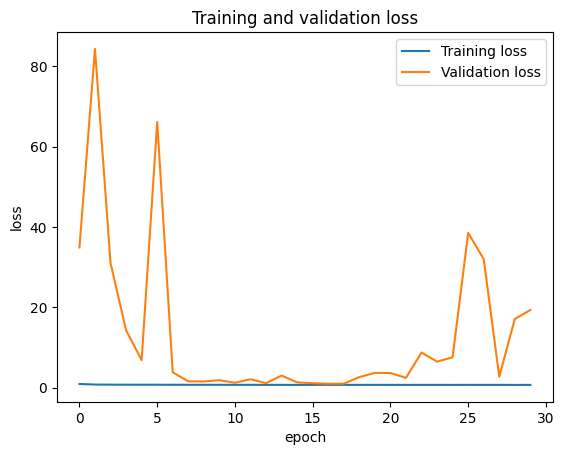

In [95]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [96]:
resnet101 = models.resnet101(weights=models.ResNet101_Weights)
resnet101.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [97]:
optimizer = optim.AdamW(resnet101.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet101, optimizer, 17,
                                                                 train_loader_resize,
                                                                 val_loader_resize)

Epoch 0
 train loss: 0.9000888383591219, train acc: 0.5323529411764706
 val loss: 2.505978133994688, val acc: 0.4583333333333333

Epoch 1
 train loss: 0.7560873503194135, train acc: 0.5705882352941176
 val loss: 1.4685600536564987, val acc: 0.4583333333333333

Epoch 2
 train loss: 0.7408620669780409, train acc: 0.5558823529411765
 val loss: 6.589184866257298, val acc: 0.4583333333333333

Epoch 3
 train loss: 0.7137437914224232, train acc: 0.55
 val loss: 2.3980581561723873, val acc: 0.4583333333333333

Epoch 4
 train loss: 0.7134318854002392, train acc: 0.5558823529411765
 val loss: 2.0886921932299933, val acc: 0.4583333333333333

Epoch 5
 train loss: 0.706202465821715, train acc: 0.5411764705882353
 val loss: 2.316840467353662, val acc: 0.4583333333333333

Epoch 6
 train loss: 0.7070203833720263, train acc: 0.5558823529411765
 val loss: 2.8375378391295576, val acc: 0.4583333333333333

Epoch 7
 train loss: 0.7075905346256846, train acc: 0.5411764705882353
 val loss: 6.762574403615659, 

In [98]:
epoch_num = 17
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

5780 17 17


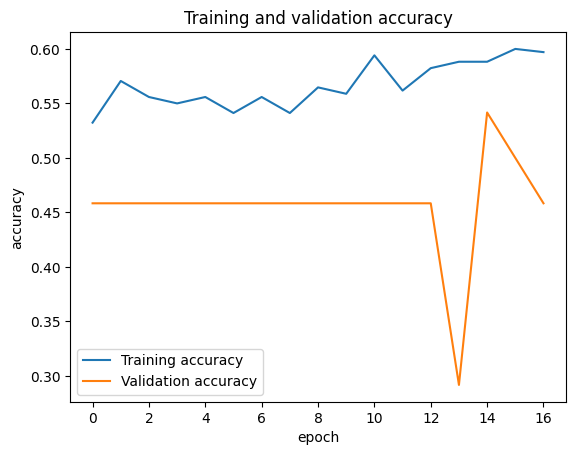

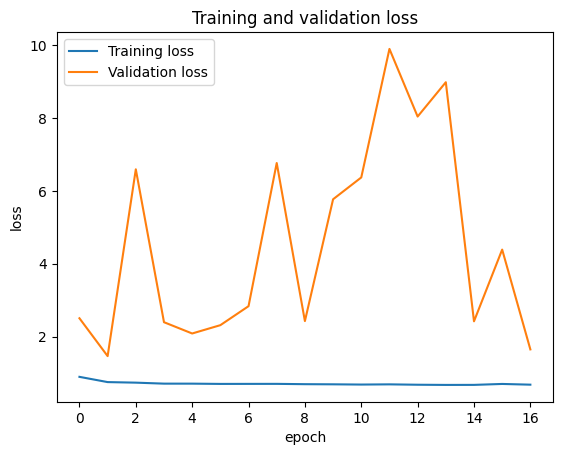

In [99]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [100]:
test_loss, test_acc = test(resnet101, test_loader_resize)
test_loss, test_acc

(1.7991246809971702, 0.6494845360824743)

In [101]:
from sklearn.metrics import classification_report

preds = make_preds(resnet101, test_loader_resize)

labels = []
for _, label in test_loader_resize:
    labels.append(label)
labels = np.array(labels)

print('Test dataset')
print(classification_report(preds, labels))

preds = make_preds(resnet101, dataloader_resize)

labels = []
for _, label in dataloader_resize:
    labels.append(label)
labels = np.array(labels)

print('All dataset')
print(classification_report(preds, labels))

Test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.98      0.66      0.79        96

    accuracy                           0.65        97
   macro avg       0.49      0.33      0.39        97
weighted avg       0.97      0.65      0.78        97

All dataset
              precision    recall  f1-score   support

           0       0.01      0.12      0.01         8
           1       0.98      0.61      0.75       477

    accuracy                           0.60       485
   macro avg       0.49      0.37      0.38       485
weighted avg       0.96      0.60      0.74       485



In [ ]:
# torch.save(resnet101.state_dict(), 'resnet101_resize.pth')

## ResNet101 + padding

In [102]:
resnet101 = models.resnet101(weights=models.ResNet101_Weights)
resnet101.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [103]:
optimizer = optim.AdamW(resnet101.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet101, optimizer, 30,
                                                                 train_loader_padding,
                                                                 val_loader_padding)

Epoch 0
 train loss: 0.8563940794754993, train acc: 0.5441176470588235
 val loss: 9.619424220425211, val acc: 0.375

Epoch 1
 train loss: 0.7254766029470107, train acc: 0.5529411764705883
 val loss: 4.9036201510431665, val acc: 0.4166666666666667

Epoch 2
 train loss: 0.697896722419297, train acc: 0.5529411764705883
 val loss: 2.9458052182259657, val acc: 0.3125

Epoch 3
 train loss: 0.6951463524252176, train acc: 0.5617647058823529
 val loss: 2.182237214098374, val acc: 0.3958333333333333

Epoch 4
 train loss: 0.7027275622986695, train acc: 0.5558823529411765
 val loss: 2.7183961659732936, val acc: 0.4791666666666667

Epoch 5
 train loss: 0.6951452624271898, train acc: 0.5647058823529412
 val loss: 2.4835922978818417, val acc: 0.375

Epoch 6
 train loss: 0.686392831933849, train acc: 0.5735294117647058
 val loss: 2.8143727613399583, val acc: 0.4166666666666667

Epoch 7
 train loss: 0.6866950046051951, train acc: 0.5764705882352941
 val loss: 2.8858305704391873, val acc: 0.375

Epoch 8

In [104]:
epoch_num = 30
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

10200 30 30


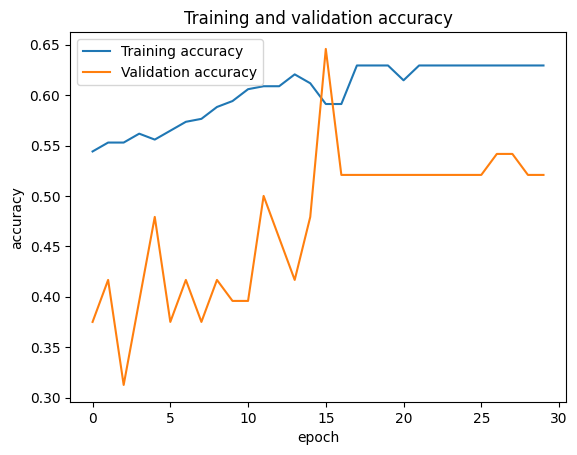

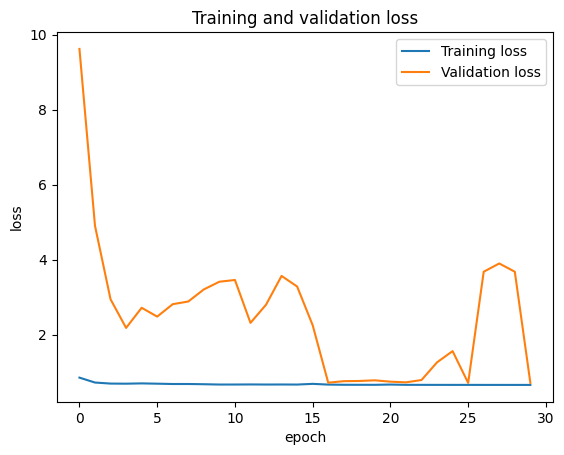

In [105]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [106]:
resnet101 = models.resnet101(weights=models.ResNet101_Weights)
resnet101.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [107]:
optimizer = optim.AdamW(resnet101.parameters())
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(resnet101, optimizer, 16,
                                                                 train_loader_padding,
                                                                 val_loader_padding)

Epoch 0
 train loss: 0.8414103421629132, train acc: 0.5441176470588235
 val loss: 2.908732254203642, val acc: 0.4166666666666667

Epoch 1
 train loss: 0.7213560286909342, train acc: 0.5588235294117647
 val loss: 1.8926157471723855, val acc: 0.3958333333333333

Epoch 2
 train loss: 0.694347227342865, train acc: 0.5794117647058824
 val loss: 3.579006438764433, val acc: 0.2916666666666667

Epoch 3
 train loss: 0.6788962121833774, train acc: 0.6235294117647059
 val loss: 3.6301092406854423, val acc: 0.3333333333333333

Epoch 4
 train loss: 0.6767367552746745, train acc: 0.5764705882352941
 val loss: 3.495003224660953, val acc: 0.375

Epoch 5
 train loss: 0.6594648135278155, train acc: 0.6205882352941177
 val loss: 3.4590626111021265, val acc: 0.3541666666666667

Epoch 6
 train loss: 0.659967126609648, train acc: 0.6264705882352941
 val loss: 3.291175831730167, val acc: 0.3541666666666667

Epoch 7
 train loss: 0.6676551230690059, train acc: 0.6205882352941177
 val loss: 3.273143032604518, v

In [108]:
epoch_num = 16
batch_size = 1
epoch_log_num = int(np.ceil(len(train_loss_log) / epoch_num))
train_loss = [0 for i in range(epoch_num)]
train_acc = [0 for i in range(epoch_num)]

for i in range(epoch_num):
    train_loss[i] = np.mean(train_loss_log[i * epoch_log_num: (i + 1) * epoch_log_num])
    train_acc[i] = np.mean(train_acc_log[i * epoch_log_num: (i + 1) * epoch_log_num])

print(len(train_loss_log), len(train_loss), len(train_acc))

5440 16 16


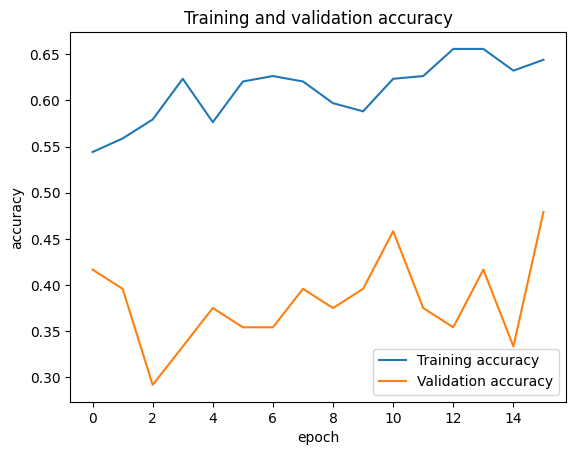

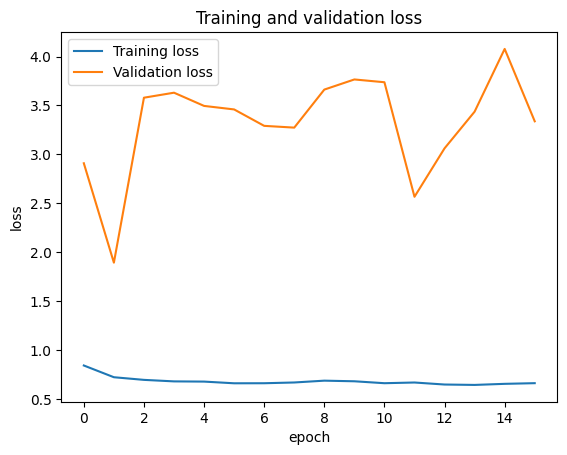

In [109]:
draw_model_plot(train_acc, val_acc_log, train_loss, val_loss_log)

In [110]:
test_loss, test_acc = test(resnet101, test_loader_padding)
test_loss, test_acc

(3.4478682604061497, 0.44329896907216493)

In [111]:
from sklearn.metrics import classification_report

preds = make_preds(resnet101, test_loader_padding)

labels = []
for _, label in test_loader_padding:
    labels.append(label)
labels = np.array(labels)

print('Test dataset')
print(classification_report(preds, labels))

preds = make_preds(resnet101, dataloader_padding)

labels = []
for _, label in dataloader_padding:
    labels.append(label)
labels = np.array(labels)

print('All dataset')
print(classification_report(preds, labels))

Test dataset
              precision    recall  f1-score   support

           0       0.44      0.35      0.39        49
           1       0.45      0.54      0.49        48

    accuracy                           0.44        97
   macro avg       0.44      0.44      0.44        97
weighted avg       0.44      0.44      0.44        97

All dataset
              precision    recall  f1-score   support

           0       0.49      0.38      0.43       244
           1       0.49      0.60      0.54       241

    accuracy                           0.49       485
   macro avg       0.49      0.49      0.48       485
weighted avg       0.49      0.49      0.48       485



In [ ]:
# torch.save(resnet101.state_dict(), 'resnet101_padding.pth')